This notebook has all the code required to emulate the results show in "Identification of neutral tumor evolution across cancer types" Williams MJ et al. Nature Genetics (in press).

Notebook is laid out as follows, the first 3 cells includes code to include the required packages, define all types and functions. The following section each have headings and short descriptions of the results generated and produces equivalent figures to those seen in the publication. In the publication, outputs from the simulations were saved and figures generated in R(v3), in this notebook we used the Gadfly package to produce inline plots.

In [95]:
#Call required packages
using Distributions
using Gadfly
using DataFrames
using GLM
using PyCall
using Colors

In [96]:
#type definitions
type prob
    # type for offspring distributions
    pu::Array{Float64,1}
    pv::Array{Float64,1}
end

type popstruct
    #Type for a population, includes an array of "alive" cells, the number of mutations each cell has acquired
    # the celltype (u(neutral) vs v (fitter)) and the parent id of the cell.
    alive::Array{Int,1}
    mutations::Array{Int,1}
    celltype::Array{Int,1}
    parentid::Array{Int,1}
end

type simstat
    #struct for the statistics that may be useful from a single simulation
    numU::Int64
    popsize::Int64
    N_generation::Int64
    popsize_event::Int64
    selection_gen::Int64
    mutantid::Int64
end

In [97]:
#function definitions
function new_pop(N,lambda) #new population size given by sampling from Poisson distribution
    w_fit=1
    rand(Poisson(N*(1+w_fit*lambda)))
end

function setupprob(s)
    #set as our baseline that E[offspring prob dist] = 1.2
    #p0=0, p1=0.8, p2= 0.2
    
    #u is our normal population, v is the population that has fitness advantage
    pu=[0,0.8,0.2]
    
    #We define our selective advantage as 1+S=E[fit]/E[normal] to get the required fitness advantage s,
    # we calculate rho which we use to modify the original offpsring probability distribution
    
    p1 = pu[2]
    p2 = pu[3]

    ρ = (s*p1 + 2*s*p2)/p1
    
    pv=[0,pu[2]-pu[2]*ρ,pu[3]+pu[2]*ρ]
    
    sum(abs(pv)) == 1.0 || error("Offspring probability distribution must sum to 1 and have no negative elements, s cannot be greater than 0.25")
    
    return prob(pu,pv)
end

function newGenerationGrow2(N,celltype,p) 
    # takes a population of pop individuals which grows according to their offspring probability distributions 
    # and samples from these distributions to get daughter cells for each cell.
    
    #celltype refers to the type, type 0 indicating normal, type 1 have a fittness advantage.

    #denote the composition of generation i+1 with vi
    newpopulation=zeros(Int,N)
    for i in 1:N
        newpopulation[i]=wsample([0,1,2],p.pu*(1-celltype[i])+p.pv*celltype[i])
    end
        
    return newpopulation
end

function tumourgrow(maxpopsize::Int64,p,mu,selectiongen::Int64,lambda)
    # Tumour grows to maxpopsize given offspring probability distribution (p) and mutation rate mu
    #
    # The simulation of tumour growth is specified by a vector which we call pop
    # and a vector called parent ID. alive designates which crypts are still "alive"
    # 1 being alive 0 being dead and parent ID designates the parents of each cell.
    # The ID simply refers to the index of the vector. For example if we grow to a size of
    # 4 crypts we might get a output that looks as follows. pop = [0,0,0,1,1,1,1],
    # and parentid = [0,1,1,2,2,3,3]. This would correspond to an idealised branching
    # process whereby 1 crypts splits into 2 which splits into 4. We can 
    # then calculate the allele frequency given that all mutations are passed onto daughter
    # crypts.
    
    #population begins with 1 cell, parentid is 0, number of mutations is zero and celltype is 0:
    alive=[1]
    mutations=[0]
    parentid=[0]
    celltype=[0]
    
    population = popstruct(alive,mutations,celltype,parentid)
    
    #define a variable selectionevent that increases by 1 at each generation, then use this
    #to specofy the generation at which a mutant allele with fitness advantage enters the population.
    selectionevent = 1
    popsize_event=0
    mutantid = 0
    
    while sum(population.alive)<maxpopsize
        if sum(population.alive) == 0
            break
        end

        #generate next generation given current generation and probabilities
        popnew = newGenerationGrow2( sum(population.alive) , population.celltype[end-sum(population.alive)+1:end] , p )

        #set parent ID of new population
        x = setID( [ zeros(Int,length(population.alive) - sum(population.alive)) ; popnew ] )
        
        # append new parentID onto previous parent IDs
        population.parentid = [population.parentid;x]
        
        #add new population onto old one. Remembering that this simply
        #corresponds to alive (1) or dead (0)
        population.alive = [zeros(Int,length(population.alive)) ; ones(Int,sum(popnew)) ]
        
        #set celltype of new population
        population.celltype = setcelltype(population.parentid,population.celltype)
        
        #increase selection event by 1
        selectionevent = selectionevent + 1
        
        #introduce fitter cell at correct generation
        if selectionevent == selectiongen
            population.celltype[end] = 1
            popsize_event = sum(population.alive)
            mutantid = population.parentid[end]
        end

    end
    
    # We now calculate the number of mutations that happen at each divison.
    # This can be done at the end.
    population.mutations = rand(Poisson(mu),length(population.alive))

    simstats = simstat(sum(population.celltype),sum(population.alive),selectionevent,popsize_event,selectiongen,mutantid)
    
    return population , simstats
end

function tumourgrow_nonzero(maxpopsize,p,mu,selectiongen,lambda)
    
    #often a tumour will not grow as 0 is an abosrbing state, function that calls tumourgrow until we get a tumour that has
    #grown to sufficent size
    alive=[1]
    mutations=[0]
    parentid=[0]
    celltype=[0]
    
    population = popstruct(alive,mutations,celltype,parentid)
    S = simstat(0,0,0,0,0,0)
    while sum(population.alive) < maxpopsize
        population,S = tumourgrow(maxpopsize,p,mu,selectiongen,lambda)
    end
    
    return population,S
    
end

function setID(vec::Array{Int,1}) #get id for parent of new mutants
    new_vec=zeros(Int,sum(vec))
    k=1
    
    for i = 1:length(vec)
        for j = 1:vec[i]
            new_vec[k] = i
            k = k + 1
        end
    end   
    return new_vec
end

function setcelltype(parentID,celltype)
    #cells inheret the type of their parent
    
    x=findin(celltype,[1])
    y=Array(Int64,1)
    new_celltype = zeros(Int64,length(parentID))
    
    for i in x
        y=findin(parentID,i)
        new_celltype[y] = 1
    end
    
    return new_celltype
end

function allele_frequency(population) 
    
    #reconstruct frequency distribution from knowledge of Parent IDs. Traces back through the tree to get allele_frequency of
    #all mutations. Uses pop struct
    
    maxID=maximum(population.parentid)
    numalive=sum(population.alive)
    counter=length(population.parentid)
    
    while maxID > 0

        index=Array(Int64,0)
        
        if population.parentid[counter-1]==maxID
            push!(index,counter-1)
        end
        
        if population.parentid[counter]==maxID
            push!(index,counter)
        end

        sumID = 0
        
        for i = 1 : length(index)
            sumID = sumID + population.alive[index[i]]
            counter=counter-1
        end
                    
        population.alive[maxID] = population.alive[maxID] + sumID
        maxID = maxID - 1
        
    end
    
    return population,numalive
end

function allele_frequency(pop,parent_ID) 
    #reconstruct frequency distribution from knowledge of Parent IDs. Traces back through the tree to get allele_frequency of
    #all mutations. Uses popalive vector and parent_ID vector
    
    popcopy = copy(pop)
    maxID=maximum(parent_ID)
    numalive=sum(pop)
    
    while maxID > 0
        
        index = findin(parent_ID,maxID)
        sumID = 0
        
        for i = 1 : length(index)
            sumID = sumID + popcopy[index[i]]
        end
                    
        popcopy[maxID] = popcopy[maxID] + sumID
        maxID = maxID - 1
        
    end
    
    return popcopy,numalive
end

function analysedata(VAF,max_range,min_range)
    
    #fit model and data that can be used to plot histogram
    
    v=min_range
    u=max_range
    
    steps=u:-0.001:v
    cumsum=Array(Int64,0)
    v=Array(Float64,0)
    
    for i in steps
        push!(cumsum,length(filter((x)->x>=i,VAF)))
        push!(v,i)
    end
    cumsum=cumsum-cumsum[1]
    
    DFcumsum = DataFrame(cumsum=cumsum,v=v)
    DFcumsum[:invVAF] = 1./DFcumsum[:v] - 1./u
    
    x,y=hist(VAF,0.0:0.01:1)
    
    #fit constrained fit using GLM fit function
    lmfit=fit(LinearModel, cumsum ~ invVAF + 0 , DFcumsum)
    DFcumsum[:prediction] = predict(lmfit)
    DFcumsum[:residuals] = residuals(lmfit)
    
    #calculate R^2 value
    rsq = 1-(sum(residuals(lmfit).^2)/sum((DFcumsum[:cumsum]-0).^2))

    return DFcumsum,lmfit,rsq
end

function pop_expand(population)
    # adjust the population vector so that
    # we include the mutations, so transforms array of cells into array of alleles.
    
    pop_new=Array(Int64,sum(population.mutations))
    k=1
    
    for i=1:length(population.alive)
        
        for j=1:population.mutations[i]
            
            pop_new[k]=population.alive[i]
            k=k+1
        
        end
    
    end
    
    population.alive=pop_new
    
    return population
end

function pop_expand(pop,muts)
    # adjust the population vector so that
    # we include the mutations
    
    pop_new=Array(Float64,sum(muts))
    k=1
            
    for i=1:length(pop)
                
        for j=1:muts[i]
                    
            pop_new[k]=pop[i]
            k=k+1
                
        end
            
    end
    
    return pop_new
end

function idealbranching(mu)
    #calculate popstruct given that all cells divide into 2 daughter cells at each generation
    
    alive=zeros(Int64,2047)
    alive[end-1023:end]=1
    
    parentid = zeros(Int64,2047)
    parentid[2:2047] = int(floor([1:0.5:(2047)/2]))
    
    mutations = rand(Poisson(mu),length(alive))
    
    celltype = zeros(Int64,2047)
        
    population = popstruct(alive,mutations,celltype,parentid)
end

function idealbranching(numgen,mu,clonalpeak)
        
    #an an ideal branching process we do not need much of the above functions. We can easily write down 
    #what the parent_id vector would look like for a given number of generations given that every cell divides into 2.
    
    x=zeros(numgen)
    power=0:1:numgen-1

    for i = 1:numgen
        x[i]=2^power[i]
    end
    
    #number of alive is given by 2^numgen
    alive=zeros(Int64,round(Int64,sum(x)))
    #alive[end-x[end]+1:end]=1
    alive[round(Int64,length(alive)-x[length(x)]+1:length(alive))]=1
    
    parentid = zeros(Int64,round(Int64,sum(x)))
    parentid[2:round(Int64,sum(x))] = round(Int64,floor(1:0.5:(round(Int64,sum(x)))/2))
    
    #draw number of mutations acquired at each division from poisson distribution
    #modify the number of mutations a founder cell has acquired
    #Note mu is the number of mutation per cell division, for a diploid cell divide this by 2
    #to get the number of mutations per genome per cell division.
    mutations = rand(Poisson(mu),length(alive))
    mutations[1]=clonalpeak*mu
    
    celltype = zeros(Int64,round(Int64,sum(x)))
        
    population = popstruct(alive,mutations,celltype,parentid)
    
end

function idealsampling(numgen,mu,clonalpeak,normalcontamination,minrange,maxrange,det_limit,ploidy,read_depth)
    #sample from an "ideal branching population".
    
    #compute population struct, calculate allele_frequencies and convert array of cells
    # to array of alleles.
    pop=idealbranching(numgen,mu,clonalpeak)
    pop,numalive=allele_frequency(pop)
    pop=pop_expand(pop)

    #set ploidy and adjust population accordingly
    pop.alive=round(Int64,pop.alive/ploidy)
    p=pop.alive/sum(pop.alive);
    
    #calculate the percentage of alleles we should sample given a target "read depth"
    samp_percent = read_depth/numalive

    #find indices of alleles above detection limit in original unsampled population.
    above_detlimit=findin(pop.alive/numalive,filter((x)->x>det_limit,pop.alive/numalive))
    
    #sample alleles using multinomial sampling
    samp_alleles=rand(Multinomial(round(Int64,sum(pop.alive)*samp_percent),p))
    
    #Calculate distribution of values to represent read depth using Binomial sampling.
    depth = rand(Binomial(numalive,samp_percent),length(samp_alleles[above_detlimit]))
    
    #Add % of normal contamination
    depth = round(depth./(1-normalcontamination))

    #calculate VAF
    VAF=samp_alleles[above_detlimit]./depth
    
    #data for histogram
    x,y=hist(VAF,0.0:0.01:1)
    DFhist = DataFrame(VAF=x[1:end-1],freq=y)
    
    DFcumsum,lmfit,rsq = analysedata(VAF,maxrange,minrange)
    
    return DFhist,DFcumsum,coef(lmfit)*log(2),rsq
end

function fullmodel_sampling(popsize,mu,clonalpeak,normalcontamination,minrange,maxrange,probmat,lambda,det_limit,read_depth)
    
    pop,S=tumourgrow_nonzero(popsize,probmat,mu,500,lambda)
    pop,numalive=allele_frequency(pop)
    pop.mutations[1]=clonalpeak
    pop=pop_expand(pop)
    
    #set ploidy and adjust population accordingly
    ploidy=2
    pop.alive=round(Int64,pop.alive/ploidy)
    p=pop.alive/sum(pop.alive);
    samp_percent = read_depth/numalive

    above_detlimit=findin(pop.alive/numalive,filter((x)->x>det_limit,pop.alive/numalive))
    
    samp_alleles=rand(Multinomial(round(Int64,sum(pop.alive)*samp_percent),p))
    
    numcells = rand(Binomial(numalive,samp_percent),length(samp_alleles[above_detlimit]))
    numcells = round(numcells./(1-normalcontamination))
    
    VAF=samp_alleles[above_detlimit]./numcells
    
    #data for histogram
    x,y=hist(VAF,0.0:0.01:1)
    DFhist = DataFrame(VAF=x[1:end-1],freq=y)
    
    DFcumsum,lmfit,rsq = analysedata(VAF,maxrange,minrange)
    
    return DFhist,DFcumsum,coef(lmfit)*lambda,rsq
end

function fullmodel_sampling(popsize,mu,clonalpeak,normalcontamination,minrange,maxrange,probmat,lambda,det_limit,read_depth,selectiongen)
    #this is for the case where we have an offspring probability function that is not p=[0,0,1]
    
    pop,S=tumourgrow_nonzero(popsize,probmat,mu,selectiongen,lambda)
    pop,numalive=allele_frequency(pop)
    pop.mutations[1]=clonalpeak
    pop=pop_expand(pop)
    
    #set ploidy and adjust population accordingly
    ploidy=2
    pop.alive=round(Int64,pop.alive/ploidy)
    p=pop.alive/sum(pop.alive);
    samp_percent = read_depth/numalive
    above_detlimit=findin(pop.alive/numalive,filter((x)->x>det_limit,pop.alive/numalive))
    
    samp_alleles=rand(Multinomial(round(Int64,sum(pop.alive)*samp_percent),p))
    
    numcells = rand(Binomial(numalive,samp_percent),length(samp_alleles[above_detlimit]))
    numcells = round(numcells./(1-normalcontamination))
    

    VAF=samp_alleles[above_detlimit]./numcells
    
    #data for histogram
    x,y=hist(VAF,0.0:0.01:1)
    DFhist = DataFrame(VAF=x[1:end-1],freq=y)
    
    DFcumsum,lmfit,rsq = analysedata(VAF,maxrange,minrange)
    
    return DFhist,DFcumsum,coef(lmfit)*lambda,rsq
end


function multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,det_limit,ploidy,read_depth)
    
    #Run simulation num_samples times to get a distribution of paramater fits
    
    #initialize arrays where mutation rate and rsq values from fits will be stored
    mu=zeros(Float64,num_samples)
    rsq=zeros(Float64,num_samples)
    
    for i = 1:num_samples
        DF,DF1,x,r = idealsampling(11,mut_rate,clon_peak,norm_cont,min_range,max_range,det_limit,ploidy,read_depth);
        mu[i] = x[1]
        rsq[i] = r
    end
    
    statvec = [mean(mu),mean(rsq)]
    return statvec,mu,rsq
end

function tumourgrow_sel(maxpopsize::Int64,p,mu,selectiongen::Int64)
    #variation of tumourgrow function where the mutation rate mu can be changed
    
    # Tumour grows to maxpopsize given probability convolution matrix and probabilities. And mutation rate mu
    #
    # The simulation of tumour growth is specified by a vector which we call pop
    # and a vector called parent ID. alive designates which crypts are still "alive"
    # 1 being alive 0 being dead and parent ID designates the parents of each crypt.
    # The ID simply refers to the index of the vector. For example if we grow to a size of
    # 4 crypts we might get a output that looks as follows. pop = [0,0,0,1,1,1,1],
    # and parentid = [0,1,1,2,2,3,3]. This would correspond to an idealised branching
    # process whereby 1 crypts splits into 2 which splits into 4. Using FD_reconstruct we can 
    # then calculate the allele frequency given that all mutations are passed onto daughter
    # crypts.
    
    selectionevent=0
    popsize_event=0
    
    
    #population begins with 1 crypt, parentID is 0, number of mutations is zero and celltype is 0:
    alive=[1]
    mutations=[0]
    parentid=[0]
    celltype=[0]
    
    population = popstruct(alive,mutations,celltype,parentid)
    
    #define a variable selectionevent that increases by 1 at each generation, then use this
    #to specofy the generation at which a mutant allele with fitness advantage enters the population.
    selectionevent = 1
    mutantid = 0
    
    while sum(population.alive)<maxpopsize
        if sum(population.alive) == 0
            break
        end

        #generate next generation given current generation and probabilities
        popnew = newGenerationGrow2( sum(population.alive) , population.celltype[end-sum(population.alive)+1:end] , p)

        #set parent ID of new population
        x = setID( append!(zeros(Int,length(population.alive) - sum(population.alive)) , popnew ) )
        
        # append new parentID onto previous parent IDs
        append!(population.parentid,x)
        
        #add new population onto old one. Remembering that this simply
        #corresponds to alive (1) or dead (0)
        population.alive = append!(zeros(Int,length(population.alive)) , ones(Int,sum(popnew)) )
        
        #set celltype of new population
        population.celltype = setcelltype(population.parentid,population.celltype)
        
        #increase selection event by 1
        selectionevent = selectionevent + 1
        
        #introduce fitter cell at correct generation
        if selectionevent == selectiongen
            population.celltype[end] = 1
            popsize_event = sum(population.alive)
            mutantid = population.parentid[end]
        end

    end
    # We now calculate the number of mutations that happen at each divison.
    # This can be done at the end.
    
    #use poisson to sample mutations for each cell
    population.mutations = rand(Poisson(mu),length(population.alive))
    
    simstats = simstat(sum(population.celltype),sum(population.alive),selectionevent,popsize_event,selectiongen,mutantid)
    
    return population , simstats
end


function idealsampling_selection(popsize,p,mu,selectiongen,clonalpeak,normalcontamination,minrange,maxrange,det_limit,ploidy,read_depth)
    #sample from an "ideal branching population".
    
    #compute population struct, calculate allele_frequencies and convert array of cells
    # to array of alleles.
    pop,S=tumourgrow_sel(popsize,p,mu,selectiongen)
    
    pop.mutations[1]=rand(Poisson(clonalpeak*mu))
    allele_frequency(pop)
    
    numalive=maximum(pop.alive)
    pop=pop_expand(pop)

    #set ploidy and adjust population accordingly
    pop.alive=round(Int64,pop.alive/ploidy)
    prob_vec=pop.alive/sum(pop.alive);
    
    #calculate the percentage of alleles we should sample given a target "read depth"
    samp_percent = read_depth/numalive

    #find indices of alleles above detection limit in original unsampled population.
    above_detlimit=findin(pop.alive/numalive,filter((x)->x>det_limit,pop.alive/numalive))
    
    #sample alleles using multinomial sampling
    samp_alleles=rand(Multinomial(round(Int64,(sum(pop.alive))*samp_percent),prob_vec))

    
    #Calculate distribution of values to represent read depth using Binomial sampling.
    #depth = rand(Binomial(numalive,samp_percent),length(samp_alleles[above_detlimit]))
    numtrials=numalive * length(pop.alive)
    depth=rand(Multinomial(round(Int64,samp_percent*numtrials),length(pop.alive)))
    
    #Add % of normal contamination
    depth = round(depth./(1-normalcontamination))

    VAF=samp_alleles[above_detlimit]./depth[above_detlimit]
    
    #data for histogram
    x,y=hist(VAF,0.0:0.01:1)
    DFhist = DataFrame(VAF=x[1:end-1],freq=y)
    
    DFcumsum,lmfit,rsq = analysedata(VAF,maxrange,minrange)
    
    
    return DFhist,DFcumsum,coef(lmfit),rsq,S
end

function tumourgrow_mutation(maxpopsize::Int64,p,mu_old,mu_new,selectiongen::Int64)
    #variation of tumourgrow function where the mutation rate mu can be changed
    
    # Tumour grows to maxpopsize given probability convolution matrix and probabilities. And mutation rate mu
    #
    # The simulation of tumour growth is specified by a vector which we call pop
    # and a vector called parent ID. alive designates which crypts are still "alive"
    # 1 being alive 0 being dead and parent ID designates the parents of each crypt.
    # The ID simply refers to the index of the vector. For example if we grow to a size of
    # 4 crypts we might get a output that looks as follows. pop = [0,0,0,1,1,1,1],
    # and parentid = [0,1,1,2,2,3,3]. This would correspond to an idealised branching
    # process whereby 1 crypts splits into 2 which splits into 4. Using FD_reconstruct we can 
    # then calculate the allele frequency given that all mutations are passed onto daughter
    # crypts.
    
    selectionevent=0
    popsize_event=0
    
    
    #population begins with 1 crypt, parentID is 0, number of mutations is zero and celltype is 0:
    alive=[1]
    mutations=[0]
    parentid=[0]
    celltype=[0]
    
    population = popstruct(alive,mutations,celltype,parentid)
    
    #define a variable selectionevent that increases by 1 at each generation, then use this
    #to specofy the generation at which a mutant allele with fitness advantage enters the population.
    selectionevent = 1
    mutantid = 0
    
    while sum(population.alive)<maxpopsize
        if sum(population.alive) == 0
            break
        end

        #generate next generation given current generation and probabilities
        popnew = newGenerationGrow2( sum(population.alive) , population.celltype[end-sum(population.alive)+1:end] , p)

        #set parent ID of new population
        x = setID( append!(zeros(Int,length(population.alive) - sum(population.alive)) , popnew ) )
        
        # append new parentID onto previous parent IDs
        append!(population.parentid,x)
        
        #add new population onto old one. Remembering that this simply
        #corresponds to alive (1) or dead (0)
        population.alive = append!(zeros(Int,length(population.alive)) , ones(Int,sum(popnew)) )
        
        #set celltype of new population
        population.celltype = setcelltype(population.parentid,population.celltype)
        
        #increase selection event by 1
        selectionevent = selectionevent + 1
        
        #introduce fitter cell at correct generation
        if selectionevent == selectiongen
            population.celltype[end] = 1
            popsize_event = sum(population.alive)
            mutantid = population.parentid[end]
        end
        
    end
    # We now calculate the number of mutations that happen at each divison.
    # This can be done at the end.
    
    simstats = simstat(sum(population.celltype),sum(population.alive),selectionevent,popsize_event,selectiongen,mutantid)
    
    #use poisson to sample mutations for each cell
    population.mutations = zeros(Int64,length(population.alive))
    population.mutations[1:simstats.mutantid] = rand(Poisson(mu_old),simstats.mutantid)
    population.mutations[(simstats.mutantid+1):end] = rand(Poisson(mu_new),length(population.mutations)-simstats.mutantid)
    
    return population , simstats
end


function idealsampling_mutation(popsize,p,mu_old,mu_new,selectiongen,clonalpeak,normalcontamination,minrange,maxrange,det_limit,ploidy,read_depth)
    
    #sample from an "ideal branching population".
    
    #compute population struct, calculate allele_frequencies and convert array of cells
    # to array of alleles.
    pop,S=tumourgrow_mutation(popsize,p,mu_old,mu_new,selectiongen)
    
    pop.mutations[1]=rand(Poisson(clonalpeak*mu_old))
    allele_frequency(pop)
    
    numalive=maximum(pop.alive)
    pop=pop_expand(pop)

    #set ploidy and adjust population accordingly
    pop.alive=round(Int64,pop.alive/ploidy)
    prob_vec=pop.alive/sum(pop.alive);
    
    #calculate the percentage of alleles we should sample given a target "read depth"
    samp_percent = read_depth/numalive

    #find indices of alleles above detection limit in original unsampled population.
    above_detlimit=findin(pop.alive/numalive,filter((x)->x>det_limit,pop.alive/numalive))
    
    #sample alleles using multinomial sampling
    samp_alleles=rand(Multinomial(round(Int64,(sum(pop.alive))*samp_percent),prob_vec))

    
    #Calculate distribution of values to represent read depth using Binomial sampling.
    #depth = rand(Binomial(numalive,samp_percent),length(samp_alleles[above_detlimit]))
    numtrials=numalive * length(pop.alive)
    depth=rand(Multinomial(round(Int64,samp_percent*numtrials),length(pop.alive)))
    
    #Add % of normal contamination
    depth = round(depth./(1-normalcontamination))

    VAF=samp_alleles[above_detlimit]./depth[above_detlimit]
    
    #data for histogram
    x,y=hist(VAF,0.0:0.01:1)
    DFhist = DataFrame(VAF=x[1:end-1],freq=y)
    
    DFcumsum,lmfit,rsq = analysedata(VAF,maxrange,minrange)
    
    
    return DFhist,DFcumsum,coef(lmfit),rsq,S
end

function mixing(popsize,pct1,pct2,μ)
    
    popsize=1000
    numalive=popsize

    clonalpeak=2
    normalcontamination=0
    minrange=0.12
    maxrange=0.24
    det_limit=0.1
    ploidy=2
    read_depth=200
    
    clonesize = rand(3:7,3)
    clonesize[1] = 3
    clonesize[2] = 4
    clonesize[3] = 2

    
    founderclone = popsize*ones(Int64,clonesize[1])
    cloneA = round(Int64,popsize*pct1)*ones(Int64,clonesize[2])
    cloneB = round(Int64,popsize*pct2)*ones(Int64,clonesize[3])
    
    popmixed = popstruct([founderclone;cloneA;cloneB],rand(Poisson(μ),sum(clonesize)),[0],[0])
    unshift!(popmixed.alive,numalive)
    unshift!(popmixed.mutations,rand(Poisson(μ)))
    popmixed=pop_expand(popmixed)

    #set ploidy and adjust population accordingly
    popmixed.alive=round(Int64,popmixed.alive/ploidy)
    prob_vec=popmixed.alive/sum(popmixed.alive);
    
    #calculate the percentage of alleles we should sample given a target "read depth"
    samp_percent = read_depth/numalive

    #find indices of alleles above detection limit in original unsampled population.
    above_detlimit=findin(popmixed.alive/numalive,filter((x)->x>det_limit,popmixed.alive/numalive))
    
    #sample alleles using multinomial sampling
    samp_alleles=rand(Multinomial(round(Int64,(sum(popmixed.alive)*samp_percent)),prob_vec))

    
    #Calculate distribution of values to represent read depth using Binomial sampling.
    numtrials=numalive * length(popmixed.alive)
    depth=rand(Multinomial(round(Int64,samp_percent*numtrials),length(popmixed.alive)))
    
    #Add % of normal contamination
    depth = round(depth./(1-normalcontamination))

    VAF=samp_alleles[above_detlimit]./depth[above_detlimit]
    
    #data for histogram
    x,y=hist(VAF,0.0:0.01:1)
    DFhist = DataFrame(VAF=x[1:end-1],freq=y)
    
    #apply model fit
    DFcumsum,lmfit,rsq = analysedata(VAF,maxrange,minrange)
    

    return DFhist,DFcumsum,coef(lmfit),rsq,VAF

end
    

func(x)="1/$(round(1/(x+(1/0.24)),3))"

func (generic function with 1 method)

# Stochastic simulation of tumour growth

Below is taken from the paper and explains the methodology of the simulation.

To further validate our analytical model and to test the robustness to the noise in NGS data, we developed a stochastic simulation of tumor growth and accumulation of mutations that allowed us to generate synthetic datasets. The model was written and analysed in the Julia programming language.  We then applied the analytical model to the simulated data to confirm that sources of noise in NGS data do not considerably impact our results. In particular, we verified that we can reliably extract input parameters of the simulation (namely the mutation rate) from “noisy” synthetic data. Confounding factors in the data include normal contamination, sampling effects, the detection limit of NGS mutation calling, and variable read depth. We simulate a tumor using a branching process with discrete generations, beginning with a single “transformed” cancer cell that gives rise to the malignancy. Under exponential growth, the population at time t will be given by:

\begin{equation}
N(t)=R^t=e^{ln(R)t}
\end{equation}

Where R is the average number of offspring per cell and the time t is in units of generations. We will consider primarily the case when R=2 (a cell always divides into 2), but we will also consider values <2, noting that R must be greater than 1 to have growth. At each division, cells acquire new mutations at a rate μ and we assume every new mutation is unique (infinite sites approximation). The number of mutations acquired by a newborn cell at division is a random number drawn from a Poisson distribution. Each cell in the population is defined by its mutations and its ancestral history (by recording it’s parent cell). Using this information we can then reconstruct the history of the whole tumor and crucially, calculate the variant allele frequency of all mutations in the population. To relate the discrete simulation to the continuous analytical model we will now re-derive equation [7] within the context of our model. As we simulate a growing tumor using discrete generations, both the mutation rate μ and per capita growth rate $\lambda=ln(R)$ are in units of generations. For an offspring probability distribution $P=(p_0,p_1,p_2)$ where $p_k=P(# of OFFSPRING =k)$, the average number of offspring R is simply given by the expected value of P:

\begin{equation}
R=E[P]=p_1+2p_2
\end{equation}

For example, for R=2 we have P=(p_0=0,p_1=0,p_2=1). By choosing different offspring probability distributions we can easily modulate the growth rate. We note that we are now expressing both μ and λ as rates per generation rather than probabilities (all rates are scaled by units of generation). This allows us to write the growth function as N(t)=e^λt with λ=ln⁡(R). Proceeding as in the main text, our cumulative number of mutations with an allelic frequency f is therefore:

\begin{equation}
M(f)=\frac{\mu}{\lambda} \left (\frac{1}{f}-\frac{1}{f_{max} }\right)
\end{equation}

Therefore, when fitting the model to our stochastic simulation we extract $\frac{\mu}{\lambda}$ from the linear fit, making it straightforward to compare the simulation with the analytical model.
NGS data only captures a small fraction of the variability in a tumor, as the resolution is often limited to alleles with frequency >10% due to sequencing depth and limitations in mutation calling. To account for this, we employ a multistage sampling scheme in our simulations. For all simulations reported here we grow the tumor to size 1024 cells, which gives a minimum allele frequency of ~0.1%, considerably smaller than the 10% attainable in next generation sequencing data. After growing the tumor and calculating the VAF for all alleles, we take a sample of the alleles in the population, noting that we are assuming the population is well mixed and has no spatial structure. We can vary the percentage of alleles we sample, thus allowing us to investigate the effect of the depth of sequencing on our results.  As we know the true allelic frequency in the simulated population, we can use the multinomial distribution to produce a sample of the “sequenced” alleles, where the probability of sampling allele i is proportional to its frequency. The probability mass function is given by:

\begin{equation}
f(x;n,p)=\frac{n!}{(x_1 !…x_k !)} \prod _{i=1}^{k}p_i^{x_i}    \quad ;\quad x_1+⋯x_k=n
\end{equation}

where $x_i$ is the sampled frequency of allele $i$, $n$ is the number of trials (the chosen percentage of alleles sampled) and $p_i$ is the probability of sampling allele i  (which has frequency $\rho_i$ in the original population):

\begin{equation}
p_i=\frac{\rho_i}{\sum_{j=1}^{k} \rho_j }
\end{equation}

The variant allele frequency VAF is therefore given by:

\begin{equation}
VAF=\frac{x_i}{N_i}
\end{equation}

Where $N_i$ is the total number of sampled cells from which every sampled allele is derived. As we are assuming a constant mutation rate $\mu$, we can assume that the percentage of alleles sampled comes from an equivalent percentage of cells. However, to include an additional element of noise that resembles the variability of read depth, we calculate a new $N_i$  for each allele $i$, which approximates the read depth.   For a desired “sequencing” depth D we calculate the corresponding percentage of the population we need to sample that will give us our desired depth. For example, for a desired depth of 100X from a population of 1000 cells, we would need to sample 10% of the population. To include some variability in depth across all alleles we use Binomial sampling so that N_i is a distribution with mean D. 
Contamination from non-tumor cells in NGS results in variant allele frequencies being underestimated. To include this effect in our simulation we can modify our N_i by an additional fraction ε – the percentage of normal contamination. Our VAF calculation thus becomes:
\begin{equation}
VAF=\frac{x_i}{N_i (1+\epsilon)}
\end{equation}
We also include detection limit in our sampling scheme, we only include alleles that have an allelic frequency greater than a specified limit in the original tumor population.


# Stochastic simulation converges to analytical solution

Here we show that our stochastic simulations can recapitulate NGS data nicely and that the stochastic simulation converges to our analytical result:

\begin{equation}
M(f)=\frac{\mu}{\lambda} \left (\frac{1}{f}-\frac{1}{f_{max} }\right)
\end{equation}

For all simulation considered here we consider an ideal branching process where all cells divide into 2 at each generation.

In [98]:
set_default_plot_size(30cm, 12cm)
#amount of normal contamination
norm_cont=0.0

#set limits of cumulative sum
min_range=0.12
max_range=0.24

#this is mutation rate per cell division, our model is in term of mutation rate per genome, 
#so for diploid genome divide by 2
mut_rate=200

#set number of clonal mutations, this is a multiplicative factor of the mutation rate
clon_peak=2

#set detection limit
det_limit=0.1

#set ploidy of genome
ploidy=2

#set target read depth
read_depth=100

@time DF,DF1,coefs,r2=idealsampling(12,mut_rate,clon_peak,norm_cont,min_range,max_range,det_limit,ploidy,read_depth);
println("mu is $(coefs[1]),r2 is $(r2)")
p1=plot(DF,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))

p2=plot(DF1,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DF1[:invVAF]), maxvalue=maximum(DF1[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DF1[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("Inverse Allelic Frequency 1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/0.25-1/max_range,1/0.15-1/max_range,1/min_range-1/max_range]))

hstack(p1,p2)

In [99]:
#enter directory for plots and data here
data_dir="data_new"
plots_dir="plots_new"
today = readall(`date +'%d.%m.%Y'`)[1:10]
sname="1_simulation"
writetable("$(data_dir)/$(today).$(sname)_processed.csv",DF1)
writetable("$(data_dir)/$(today).$(sname)_raw.csv",DF)
draw(PDF("$(plots_dir)/$(today).$(sname)_hist.pdf", 12cm, 12cm), p1)
draw(PDF("$(plots_dir)/$(today).$(sname)_cumsum.pdf", 16cm, 12cm), p2)

0.206797 seconds (1.09 M allocations: 65.270 MB, 7.35% gc time)
mu is 103.33555599444436,r2 is 0.9993150476639453


# Fit Distribution

Here we confirm that over a large number of simulations we can accurately recover the mutation rate from the model fit. The slight overestimation is likely due to some of the elements of noise introduced we bias our results.

In [100]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=2
det_limit=0.1
ploidy=2

#num samples is the number of times we run the same simulation, for the results of the paper we used 10,000
num_samples=100
numgen=11
read_depth=100

@time statvec,mu,rsq=multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,det_limit,ploidy,read_depth)
DF = DataFrame(mu=mu,rsq=rsq);

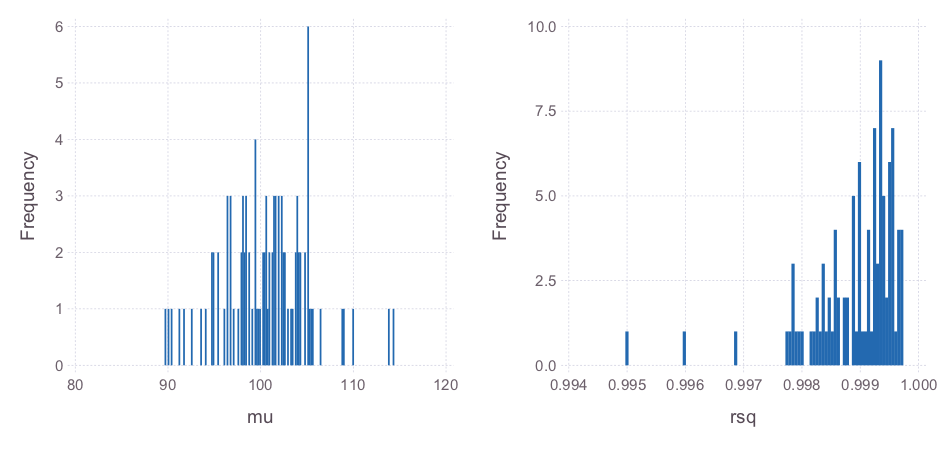

In [101]:
set_default_plot_size(25cm, 12cm)
p1=plot(DF,x="mu",Geom.histogram,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=colormap("blues")[80]),
Guide.xlabel("mu"),Guide.ylabel("Frequency"),Scale.x_continuous(minvalue=80, maxvalue=120))

p2=plot(DF,x="rsq",Geom.histogram,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=colormap("blues")[80]),
Guide.xlabel("rsq"),Guide.ylabel("Frequency"))

hstack(p1,p2)

In [102]:
mean(DataArray(DF),1) #mean mutation rate and R^2 values

6.602882 seconds (61.41 M allocations: 3.325 GB, 12.09% gc time)


1x2 DataArrays.DataArray{Float64,2}:
 100.541  0.998924

In [103]:
sname="mutation_estimates_dist"
writetable("$(data_dir)/$(today).$(sname).csv",DF)
draw(PDF("$(plots_dir)/$(today).$(sname)_mu.pdf", 15cm, 12cm), p1)
draw(PDF("$(plots_dir)/$(today).$(sname)_rsq.pdf", 15cm, 12cm), p2)

In [104]:
DF

100x2 DataFrames.DataFrame
| Row | mu      | rsq      |
|-----|---------|----------|
| 1   | 92.6081 | 0.998274 |
| 2   | 98.5036 | 0.999273 |
| 3   | 98.4531 | 0.999234 |
| 4   | 91.1762 | 0.999453 |
| 5   | 113.762 | 0.998784 |
| 6   | 100.919 | 0.999569 |
| 7   | 100.587 | 0.999326 |
| 8   | 90.0882 | 0.999713 |
| 9   | 101.475 | 0.998459 |
| 10  | 104.347 | 0.99958  |
| 11  | 98.3632 | 0.99872  |
⋮
| 89  | 102.453 | 0.999496 |
| 90  | 94.8996 | 0.999513 |
| 91  | 101.689 | 0.999247 |
| 92  | 100.596 | 0.998889 |
| 93  | 100.862 | 0.998436 |
| 94  | 105.093 | 0.999242 |
| 95  | 96.4124 | 0.999578 |
| 96  | 103.815 | 0.99898  |
| 97  | 96.4441 | 0.999383 |
| 98  | 98.342  | 0.997867 |
| 99  | 100.534 | 0.998252 |
| 100 | 102.345 | 0.999374 |

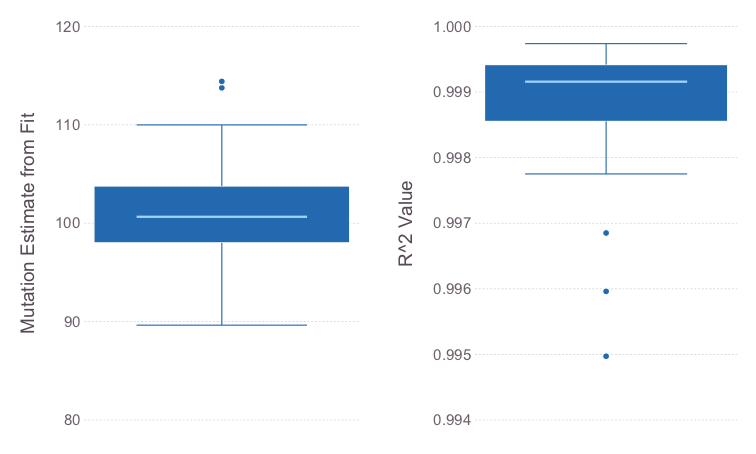

In [105]:
set_default_plot_size(20cm, 12cm)
p1=plot(DF,y="mu",Geom.boxplot,Stat.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("blues")[80],boxplot_spacing=0.5cm),
Guide.xlabel(""),Guide.ylabel("Mutation Estimate from Fit"))
p2=plot(DF,y="rsq",Geom.boxplot,Stat.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("blues")[80],boxplot_spacing=0.5cm),
Guide.xlabel(""),Guide.ylabel("R^2 Value"))
p=hstack(p1,p2)

In [106]:
draw(PDF("$(plots_dir)/$(today).mut_dist_boxplot.pdf", 15cm, 12cm), p)

# Clonal Peak

Here we confirm the robustness to the number of clonal mutations.

In [107]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=[0,2,4]
det_limit=0.1
ploidy=2
numgen=11
stats = zeros(Float64,3,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
read_depth=100
@time for i in clon_peak
    stats[j,:],DFmu[symbol("$(round(Int64,(mut_rate/2) * i))")],DFrsq[symbol("$(round(Int64,(mut_rate/2) * i))")] = 
    multsample(numgen,num_samples,mut_rate,i,norm_cont,min_range,max_range,
    det_limit,ploidy,read_depth)
    j+=1
end

 18

In [108]:
stats

3x2 Array{Float64,2}:
 100.848  0.998929
 100.396  0.999014
 101.2    0.999105

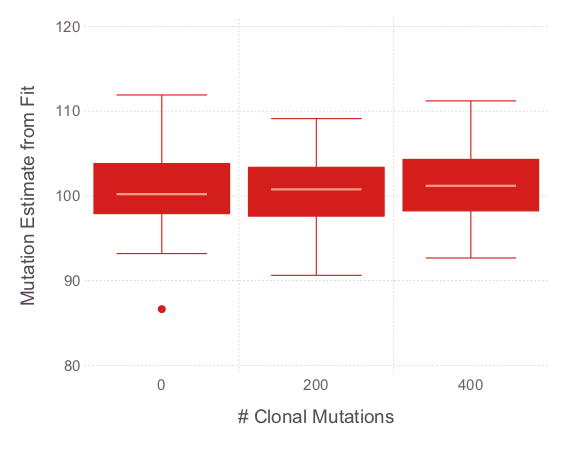

In [109]:
set_default_plot_size(15cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("# Clonal Mutations"),Guide.ylabel("Mutation Estimate from Fit"))

In [110]:
sname="clonalpeakmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)

sname="clonalpeakrsq"
writetable("$(plots_dir)/$(today).$(sname).csv",DFrsq)


# Normal Contamination

Here we confirm the robustness to the amount of normal contamination.

In [111]:
norm_cont=[0.0,0.1,0.2,0.3,0.4,0.5]
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=0.1
ploidy=2
read_depth=100
#num_samples=100
numgen=11
stats = zeros(Float64,6,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in norm_cont
    stats[j,:],DFmu[symbol("$(Int64(i*100)) %")],DFrsq[symbol("$(Int64(i*100)) %")] = 
    multsample(numgen,num_samples,mut_rate,clon_peak,i,min_range,max_range,
    det_limit,ploidy,read_depth)
    j+=1
end

In [112]:
stats

.813059 seconds (184.30 M allocations: 10.020 GB, 11.55% gc time)


6x2 Array{Float64,2}:
 101.079   0.998976
  95.4516  0.997722
  89.8543  0.996231
  77.4518  0.99786 
  59.4197  0.988249
  47.9107  0.992456

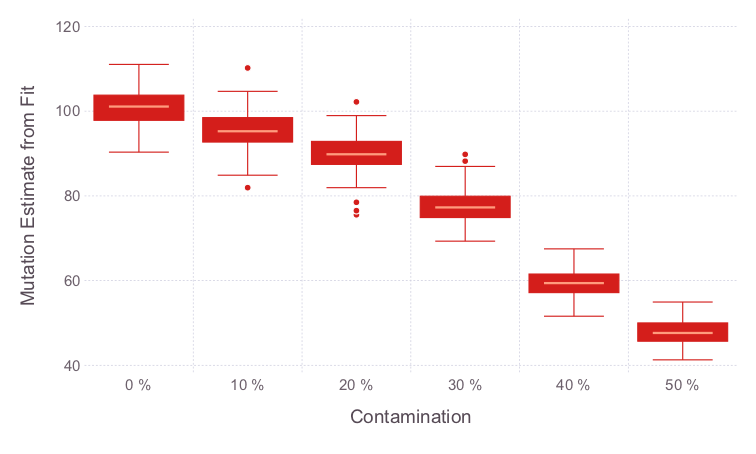

In [113]:
set_default_plot_size(20cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Contamination"),Guide.ylabel("Mutation Estimate from Fit"))

In [114]:
sname="contaminationmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)
draw(SVG("$(plots_dir)/$(today).$(sname).svg", 15cm, 12cm), p)
sname="contaminationrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)


In [115]:
#corrected contamination
DFmu[2] = DFmu[2].*(1+0.1);
DFmu[3] = DFmu[3].*(1+0.2);
DFmu[4] = DFmu[4].*(1+0.3);
DFmu[5] = DFmu[5].*(1+0.4);
DFmu[6] = DFmu[6].*(1+0.5);

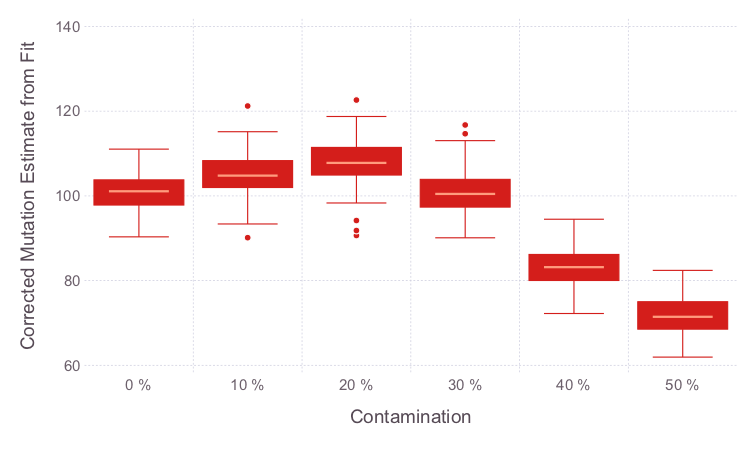

In [116]:
set_default_plot_size(20cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Contamination"),Guide.ylabel("Corrected Mutation Estimate from Fit"))

In [117]:
sname="correctedcontaminationmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)
draw(SVG("$(plots_dir)/$(today).$(sname).svg", 15cm, 12cm), p)
sname="correctedcontaminationrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)

# Detection Limit

In [118]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=[0.01,0.05,0.1]
ploidy=2
read_depth=100
#num_samples=100
numgen=11
stats = zeros(Float64,3,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in det_limit
    stats[j,:],DFmu[symbol("$(round(Int64,i*100)) %")],DFrsq[symbol("$(round(Int64,i*100)) %")] = 
    multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,
    i,ploidy,read_depth)
    j+=1
end

In [119]:
stats

3x2 Array{Float64,2}:
 103.408  0.99861 
 102.898  0.998725
 101.285  0.999018

In [120]:
set_default_plot_size(20cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Detection Limit"),Guide.ylabel("Mutation Estimate from Fit"))

In [121]:
sname="detection_limitmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)
draw(SVG("$(plots_dir)/$(today).$(sname).svg", 15cm, 12cm), p)
sname="detection_limitrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)

# Read Depth

In [122]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=0.1
ploidy=2
read_depth=[25,50,75,100]
#num_samples=100
numgen=11
stats = zeros(Float64,4,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in read_depth
    stats[j,:],DFmu[symbol("$(Int64(i)) ")],DFrsq[symbol("$(Int64(i))")] = multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,
    det_limit,ploidy,i)
    j+=1
    println("finished $(i)")
end

finished 25
finished 50
finished 75
finished 100


In [123]:
stats

4x2 Array{Float64,2}:
  89.4817  0.994074
  99.962   0.997326
 101.632   0.998731
 100.788   0.999034

In [124]:
set_default_plot_size(25cm, 12cm)
p1=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Read Depth"),Guide.ylabel("Mutation Estimate from Fit"))
p2=plot(stack(DFrsq),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Read Depth"),Guide.ylabel("R^2"))

hstack(p1,p2)

In [125]:
sname="read_depthmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)

sname="read_depthrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p2)


# Mutation Rate

In [126]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=[5,20,200]
clon_peak=1
det_limit=0.1
ploidy=2
read_depth=100
#num_samples=100
numgen=11
stats = zeros(Float64,3,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in mut_rate
    println(i)
    stats[j,:],DFmu[symbol("$(Int64(i))")],DFrsq[symbol("$(Int64(i))")] = multsample(numgen,num_samples,i,clon_peak,norm_cont,min_range,max_range,
    det_limit,ploidy,read_depth)
    j+=1
end

5
20
200


In [127]:
#remember due to ploidy mutation rate is half on input
stats

3x2 Array{Float64,2}:
   2.45006  0.968117
   9.95213  0.992785
 100.607    0.999036

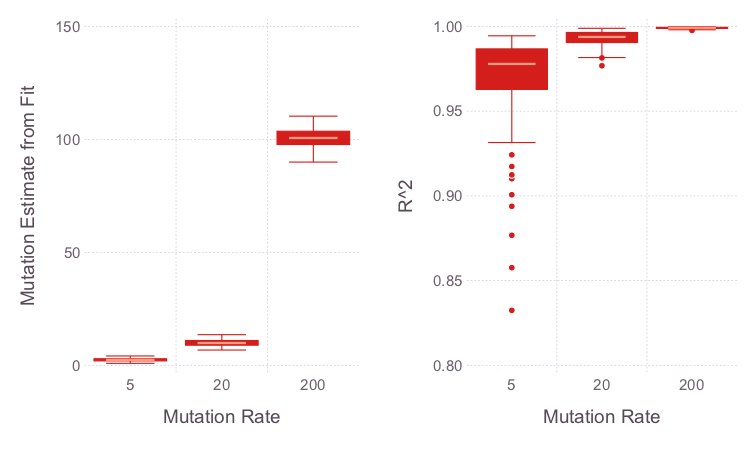

In [128]:
set_default_plot_size(20cm, 12cm)
p1=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Mutation Rate"),Guide.ylabel("Mutation Estimate from Fit"))
p2=plot(stack(DFrsq),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Mutation Rate"),Guide.ylabel("R^2"))
hstack(p1,p2)

In [129]:
sname="mut_ratemu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)

sname="mut_ratersq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p2)


# Different Growth rates

Here we demonstrate that we still recover the mutation rate and neutrality under different growth regimes, but that the variance in the mutation rate estimates ($\mu$) is more variable and that we would missclassify a higher proportion of tumours as non - nuetral due to poorer $R^2$ values.

In [130]:
probmat=[[0.0,0.0,1] [0.05,0.1,0.85] [0.1,0.2,0.7] [0.2,0.2,0.6] [0.2,0.4,0.4]]
norm_cont=0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=0.1
read_depth=100
DFmu=DataFrame()
DFrsq=DataFrame()

for j = 1:length(probmat[1,:])
    
    println(j)
    lambda = log(probmat[2,j]+2*probmat[3,j])
    mu=zeros(Float64,num_samples)
    rsq=zeros(Float64,num_samples)
    p=prob(probmat[:,j],probmat[:,j])
    
    for i = 1:num_samples
        DF1,DF2,x,r=fullmodel_sampling(1000,mut_rate,clon_peak,norm_cont,min_range,max_range,p,lambda,det_limit,read_depth);
        mu[i]=x[1]
        rsq[i] =r
    end
    
    DFmu[symbol("ln($(round(probmat[2,j]+2*probmat[3,j],3)))")]=mu
    DFrsq[symbol("ln($(round(probmat[2,j]+2*probmat[3,j],3)))")]=rsq
end

1
2
3
4
5


In [131]:
set_default_plot_size(15cm, 12cm)
p1=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Growth Rate"),Guide.ylabel("Mutation Estimate from Fit"))

In [132]:
set_default_plot_size(15cm, 12cm)
p3=plot(stack(DFrsq),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Growth Rate"),Guide.ylabel("R^2"))

In [133]:
sname="different.lambda_mu"

writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)


sname="different.lambda_rsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)

# Mixing Clones

Now we consider the case of 2 mixed clones which may arise as described in the online methods of the paper.

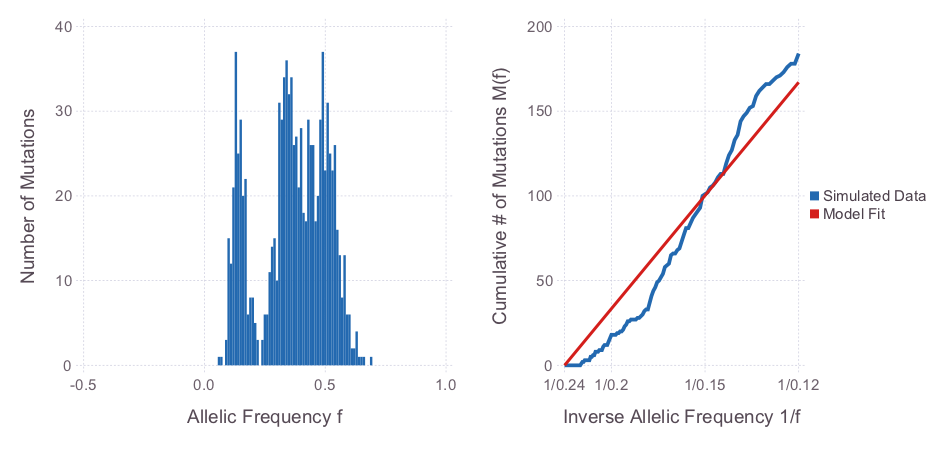

In [134]:
set_default_plot_size(25cm, 12cm)
@time DFhist,DFfit,coefficient,rsq,tV=mixing(1000,0.7,0.3,100)
p1=plot(DFhist,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))
p2=plot(DFfit,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DFfit[:invVAF]), maxvalue=maximum(DFfit[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DFfit[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("Inverse Allelic Frequency 1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/(max_range)-1/max_range,1/0.2-1/max_range,1/0.15-1/max_range,1/0.12-1/max_range]))

println("R^2=$rsq")
hstack(p1,p2)

In [135]:
sname="mixing"

writetable("$(data_dir)/$(today).$(sname).hist.csv",DFhist)
writetable("$(data_dir)/$(today).$(sname).fit.csv",DFfit)
draw(PDF("$(data_dir)/$(today).$(sname).histogram.pdf", 15cm, 12cm), p1)
draw(PDF("$(data_dir)/$(today).$(sname).cumulative.pdf", 15cm, 12cm), p2)

0.073999 seconds (162.09 k allocations: 5.683 MB, 20.20% gc time)
R^2=0.964332974328806


# Selection

Here we consider the effect of strong selection occurring early during tumour growth. We define the second population with $Q=(q_0,q_1,q_2)$, with $q_2>p_2$. We print out the population size when the fitter mutant is introduced, as can be seen the presence of selection can only be seen when the population size is small due to the limit of detectability. Included are some numbers to seed the random number generator that produces examples of histograms clearly influenced by selection.

In [136]:
normalcontamination = 0
min_range = 0.12
max_range = 0.24
mu=100
clonalpeak = 2
det_limit = 0.1
read_depth = 100
popsize = 1000
ploidy = 2

#selective advantage  = 1+adv
adv = 0.5
p=setupprob(adv)

#generation the advantagous mutant is introduced
selectiongen=25


25

R^2 = 0.9456865140758342


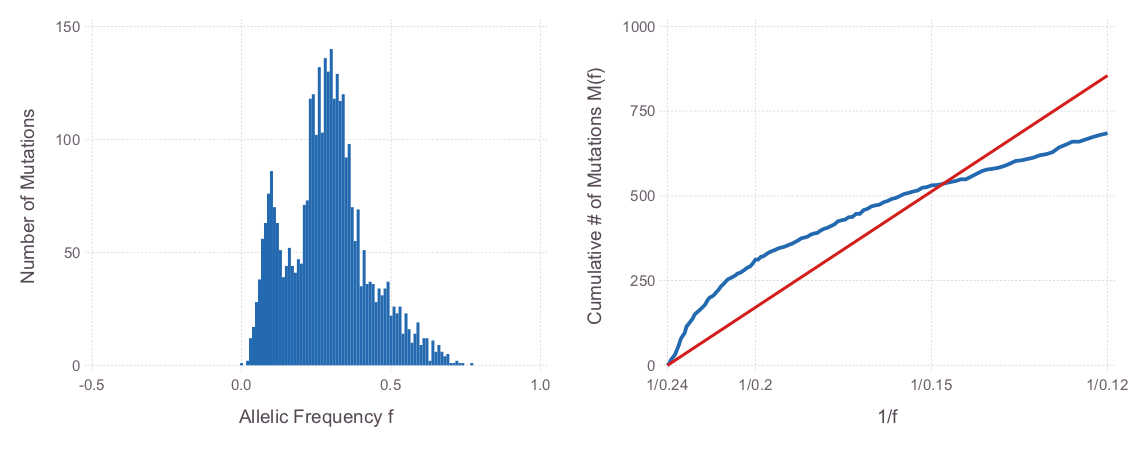

In [137]:
examples = [5,7,9,17,22,25,28,41]

#seed the random number generator with one of the above for some clear examples of VAF histograms influenced by selection
srand(examples[1])
DFhist,DFfit,coefficient,rsq,S=idealsampling_selection(popsize,p,mu,selectiongen,clonalpeak,normalcontamination,min_range,max_range,det_limit,ploidy,read_depth);
set_default_plot_size(30cm, 12cm)

p1=plot(DFhist,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))

p2=plot(DFfit,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DFfit[:invVAF]), maxvalue=maximum(DFfit[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DFfit[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
#Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/(max_range)-1/max_range,1/0.2-1/max_range,1/0.15-1/max_range,1/0.12-1/max_range]))

println("R^2 = $rsq")
println("population size when fitter mutant introduced = $(S.popsize_event)")
println("number of cells of fitter type = $(S.numU)")


hstack(p1,p2)

In [138]:
sname="selection.$(adv)"

writetable("$(data_dir)/$(today).$(sname).hist.csv",DFhist)
writetable("$(data_dir)/$(today).$(sname).fit.csv",DFfit)
draw(PDF("$(data_dir)/$(today).$(sname).histogram.pdf", 15cm, 12cm), p1)
draw(PDF("$(data_dir)/$(today).$(sname).cumulative.pdf", 15cm, 12cm), p2)

population size when fitter mutant introduced = 65
number of cells of fitter type = 745


# Change in mutation rate

Finally we show that a change in mutation rate also influences the distribution.

In [139]:
normalcontamination = 0
min_range = 0.12
max_range = 0.24

#after a few generations we get a 10fold increase in the mutation rate
mu_old=10
mu_new=100
clonalpeak = 2
det_limit = 0.1
read_depth = 100
popsize = 1000
ploidy = 2

#set selective advantage to 0 as we are only interested in the effect of a change in the mutation rate
adv = 0.0
p=setupprob(adv)
p=prob([0.0,0.0,1.0],[0.0,0.0,1.0])

#generation the phenotype with higher mutation rate introduced mutant is introduced
selectiongen=3


3

R^2 = 0.9652022233880752


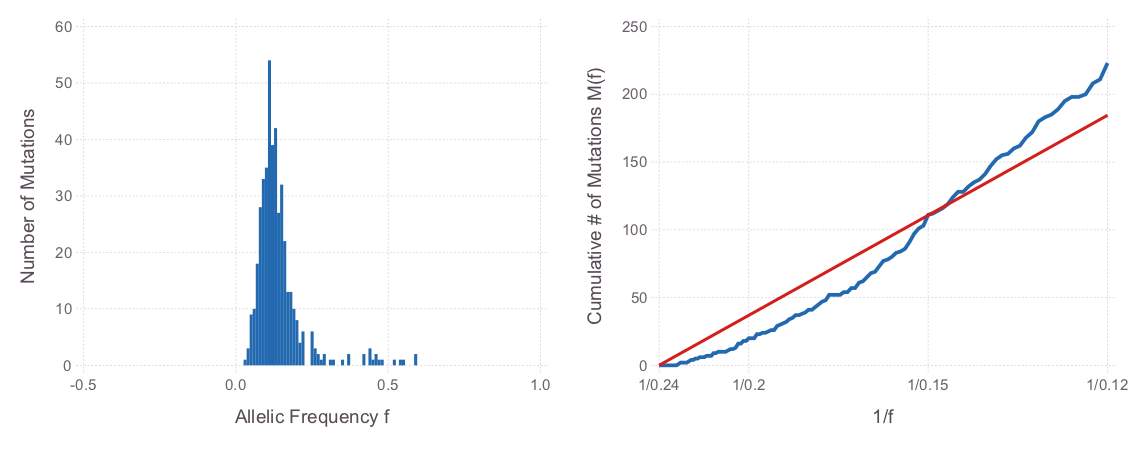

In [140]:
DFhist,DFfit,coefficient,rsq,S=idealsampling_mutation(popsize,p,mu_old,mu_new,selectiongen,clonalpeak,normalcontamination,min_range,max_range,det_limit,ploidy,read_depth);
set_default_plot_size(30cm, 12cm)

p1=plot(DFhist,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))

p2=plot(DFfit,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DFfit[:invVAF]), maxvalue=maximum(DFfit[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DFfit[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
#Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/(max_range)-1/max_range,1/0.2-1/max_range,1/0.15-1/max_range,1/0.12-1/max_range]))

println("R^2 = $rsq")
println("population size when higher mutation rate phenotype introduced = $(S.popsize_event)")

hstack(p1,p2)

In [141]:
sname="change_mu"

writetable("$(data_dir)/$(today).$(sname).hist.csv",DFhist)
writetable("$(data_dir)/$(today).$(sname).fit.csv",DFfit)
draw(PDF("$(data_dir)/$(today).$(sname).histogram.pdf", 15cm, 12cm), p1)
draw(PDF("$(data_dir)/$(today).$(sname).cumulative.pdf", 15cm, 12cm), p2)

population size when higher mutation rate phenotype introduced = 4
